In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
batch_size = 120
num_classes = 10
epochs = 100
latent_dim = 128

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [4]:
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim + num_classes,)),
        
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

def make_discriminator():
    image_in = keras.Input(shape=(28, 28, 1))
    
    conv1 = layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same")
    c1 = conv1(image_in)
    relu1 = layers.LeakyReLU(alpha=0.2)
    r1 = relu1(c1)
    conv2 = layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same")
    c2 = conv2(r1)
    relu2 = layers.LeakyReLU(alpha=0.2)
    r2 = relu2(c2)
    
    flatten = layers.Flatten()
    f = flatten(r2)
    
    #output real fake
    dense = layers.Dense(1)
    output_realfake = dense(f)
    
    #output digit label
    dense128 = layers.Dense(128)
    d2 = dense128(f)
    dense10 = layers.Dense(num_classes, activation="softmax")
    labels = dense10(d2)
    
    model = keras.Model(inputs=image_in, outputs=[output_realfake, labels], name="discriminator")
    
    return model
discriminator = make_discriminator()

In [5]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        
        #if isinstance(real_images, tuple):
        #    real_images = real_images[0]
        
        real_images = data[0]
        real_labels = data[1]        
        
            
        # Sample random points in the latent space
        batch_size = real_images.shape[0]
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        #random_labels = tf.random.uniform(shape=(batch_size,), minval=0, maxval=10, dtype=tf.int32)
        #random_labels = tf.keras.utils.to_categorical(random_labels, num_classes=10, dtype=tf.int32)
        random_labels = real_labels
        
        gen_input_vectors = tf.concat([random_latent_vectors, random_labels], axis=1)

        # Decode them to fake images
        generated_images = self.generator(gen_input_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images; 1 = fake, 0 = real
        realfakelabels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        
        digitlabels = tf.concat([random_labels, real_labels], axis=0)
        
        
        # Add random noise to the labels - important trick!
        realfakelabels += 0.05 * tf.random.uniform(tf.shape(realfakelabels))
        

        # Train the discriminator
        with tf.GradientTape() as tape:
            realfakepred, labelpred = self.discriminator(combined_images)
            d_rf_loss = self.loss_fn[0](realfakelabels, realfakepred)
            d_label_loss = self.loss_fn[1](digitlabels, labelpred)
        grads = tape.gradient([d_rf_loss, d_label_loss], self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        
        
        
        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        #random_labels = tf.random.uniform(shape=(batch_size,), minval=0, maxval=10, dtype=tf.int32)
        #random_labels = tf.keras.utils.to_categorical(random_labels, num_classes=10, dtype='int32')
        random_labels = real_labels
        
        gen_input_vectors = tf.concat([random_latent_vectors, random_labels], axis=1)

        
        # Assemble labels that say "all real images"
        misleading_realfake = tf.zeros((batch_size, 1))
    

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            realfakepred, labelpred = self.discriminator(self.generator(gen_input_vectors))
            g_rf_loss = self.loss_fn[0](misleading_realfake, realfakepred)
            g_label_loss = self.loss_fn[1](random_labels, labelpred)
        grads = tape.gradient([g_rf_loss, g_label_loss], self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": (d_rf_loss + d_label_loss), "g_loss": (g_rf_loss + g_label_loss)}


In [6]:
cond_gan = GAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=[
        keras.losses.BinaryCrossentropy(from_logits=True), 
        keras.losses.CategoricalCrossentropy()
    ],
)

In [7]:
#cond_gan.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
cond_gan.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
#cond_gan.fit(dataset, epochs=20)

Epoch 1/100
500/500 [==============================] - 107s 199ms/step - d_loss: 1.4707 - g_loss: 8.4757
Epoch 2/100
500/500 [==============================] - 100s 200ms/step - d_loss: 1.4598 - g_loss: 17.4436
Epoch 3/100
500/500 [==============================] - 100s 200ms/step - d_loss: 0.9246 - g_loss: 1.7340 ETA: 0s - d_loss: 0.9251 - g_loss: 
Epoch 4/100
500/500 [==============================] - 100s 200ms/step - d_loss: 0.7857 - g_loss: 1.1424
Epoch 5/100
500/500 [==============================] - 100s 200ms/step - d_loss: 0.7067 - g_loss: 1.1309
Epoch 6/100
500/500 [==============================] - 100s 200ms/step - d_loss: 0.6906 - g_loss: 1.3107
Epoch 7/100
500/500 [==============================] - 100s 200ms/step - d_loss: 0.7794 - g_loss: 1.0634
Epoch 8/100
500/500 [==============================] - 100s 200ms/step - d_loss: 0.7486 - g_loss: 0.9224
Epoch 9/100
500/500 [==============================] - 100s 200ms/step - d_loss: 0.7573 - g_loss: 0.9554
Epoch 10/100
500/5

500/500 [==============================] - 100s 200ms/step - d_loss: 0.6756 - g_loss: 0.8284
Epoch 66/100
500/500 [==============================] - 100s 200ms/step - d_loss: 0.6781 - g_loss: 0.8073 - d_loss: 0.6787 - 
Epoch 67/100
500/500 [==============================] - 100s 200ms/step - d_loss: 0.6826 - g_loss: 0.8156 48s - d_loss: 
Epoch 68/100
500/500 [==============================] - 100s 200ms/step - d_loss: 0.6857 - g_loss: 0.802642s - d_loss: 0 - ET - ETA: 2s - d_loss:
Epoch 69/100
500/500 [==============================] - 100s 200ms/step - d_loss: 0.6835 - g_loss: 0.8024
Epoch 70/100
500/500 [==============================] - 100s 200ms/step - d_loss: 0.6882 - g_loss: 0.8032
Epoch 71/100
500/500 [==============================] - 100s 200ms/step - d_loss: 0.6917 - g_loss: 0.7908
Epoch 72/100
500/500 [==============================] - 100s 200ms/step - d_loss: 0.6911 - g_loss: 0.7945
Epoch 73/100
500/500 [==============================] - 100s 200ms/step - d_loss: 0.6919 -

In [59]:

#cond_gan.save("GAN")
generator.save("generator")
discriminator.save("discriminator")

INFO:tensorflow:Assets written to: generator\assets
INFO:tensorflow:Assets written to: discriminator\assets


In [10]:
def generate_digit(n = 0):
    
    noise = np.random.randn(latent_dim)
    gen_input = tf.reshape(noise, (1, latent_dim))
    gen_input = np.concatenate([gen_input, tf.reshape(np.eye(10)[n], (1, 10))], axis=1)
    
    image = generator.predict(gen_input)
    image *= 256
    image = image.astype(np.uint8)
    image = image[0]
    
    fig = plt.figure
    plt.imshow(image, cmap='gray')
    plt.show()
    plt.close()
    
    return discriminator.predict(generator.predict(gen_input))

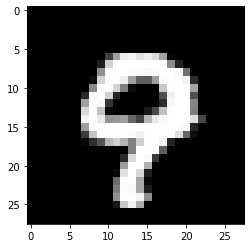

[array([[-0.13064066]], dtype=float32),
 array([[5.54356298e-14, 4.75499038e-26, 2.66139605e-16, 6.17236507e-18,
         3.73538450e-10, 3.29490893e-16, 1.25472631e-22, 1.04990745e-08,
         1.27579306e-12, 1.00000000e+00]], dtype=float32)]

In [58]:
generate_digit(9)

In [ ]:
def generate_good_digit(n = 0):
    
    
    while 1>0:
        noise = np.random.randn(latent_dim)
        gen_input = tf.reshape(noise, (1, latent_dim))
        image = generator.predict(gen_input)
        if(discriminator.predict(image) < 0.1):
            break
    
    image *= 256
    image = image.astype(np.uint8)
    image = image[0]
    
    fig = plt.figure
    plt.imshow(image, cmap='gray')
    plt.show()
    plt.close()
    
    return discriminator.predict(generator.predict(gen_input))

In [ ]:
generate_good_digit()